<h1>Detecting bacteria infections - Demo Version</h1>

For confidentiality reasons, there are 2 version of code: "Original version code" and "Demo version code".

"Original version code" has 40 training samples and 10 test samples, but data is not available. 

"Demo version code", operates only with one sample. The purpose is to display a glimpse of the data that has been worked on.

Load information from Excel file into dataframes. 

There were 50 experiments run. 

Every experiment consists of the following data:
<ul>
    <li>input: 2d points (X/V, Y/µA), where X/V was in the interval [-0.75, 0.75]. </li>
    <li>output: siderophore (Pyociannina, Aerobactin, Enterobactin) and its respective quantity in mmol (0,25,50,100).</li>
</ul>

A dictionary of dataframes was created.

Because of the noise, information has been filtered. Therefore, only the rows with X/V in the interval [-0.6,0.5] were taken into consideration.

<b>Demo version reads only one sample</b>

In [92]:
import pandas as pd
import openpyxl

# Load the Excel file
file_path = '../data/Data.xlsx'
wb = openpyxl.load_workbook(file_path, data_only=True)
sheet_name = 'Autolab_data_points'
ws = wb[sheet_name]

# Read data into separate dataframes
dfs = {}
# for start_col in range(1, ws.max_column, 6):
for start_col in range(1, 6, 6):
    # Read the dataframe name from the first cell of the column
    df_name = ws.cell(row=1, column=start_col).value
    
    # Read data into a dataframe, starting from index 2 for 'X' and index 3 for 'Y'
    data = []
    for row in range(2, ws.max_row + 1):
        x_value = ws.cell(row=row, column=start_col + 1).value
        y_value = ws.cell(row=row, column=start_col + 2).value
        data.append([x_value, y_value])
    
    df = pd.DataFrame(data, columns=['X', 'Y'])
    
    # Drop the first row
    df = df.iloc[1:]
    
    # Store the dataframe with its name
    dfs[df_name] = df

# Function to convert object columns to float and filter rows
def convert_and_filter(df):
    # Convert object columns to float
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                print(f"Warning: Column {col} in DataFrame {df_name} could not be converted to float.")
    
    # Filter rows based on the condition for column 'X'
    df = df[(df['X'] > -0.6) & (df['X'] < 0.5)]
    return df

# Apply conversion and filtering to each dataframe in dfs
for df_name in dfs:
    dfs[df_name] = convert_and_filter(dfs[df_name])

# Print the filtered dataframes for verification
for df_name, df in dfs.items():
    print(f"DataFrame: {df_name}")
    print(df.head())
    print()

DataFrame: E1
           X         Y
61 -0.597839  0.000010
62 -0.592804  0.000010
63 -0.587769  0.000010
64 -0.582733  0.000009
65 -0.577698  0.000009



Print shape of dataframes after filtering original data, for X/V in the interval [-0.6,0.5].

Each dataframe from the dictionary contains 219 rows and 2 columns.

In [93]:
for df_name in dfs:
    print(dfs[df_name].shape)

(219, 2)


Print dataframe from dictionary, based on experiment name

In [94]:
dfs['E1']

,X,Y
61,-0.597839,0.000010
62,-0.592804,0.000010
63,-0.587769,0.000010
64,-0.582733,0.000009
65,-0.577698,0.000009
...,...,...
275,0.479736,0.000009
276,0.484772,0.000010
277,0.489807,0.000010
278,0.494843,0.000010


Create dataframe to store the main features of the plotes determined by the experiments:
<ul>
    <li>MaxPeak_X: value of X/V for the peak of the plot</li>
    <li>MaxPeak_Y: value of Y/µA for the peak of the plot</li>
    <li>NoPeaks: number of peaks in the plot</li>
    <li>Area: area under the curve</li>
</ul>

In [95]:
# Create data for each column
data = {
    'MaxPeak_X': [],
    'MaxPeak_Y': [],
    'NoPeaks': [],
    'Area': [],
}

# Create the DataFrame
df_Input = pd.DataFrame(data)

Calculate, for each experiment, the following features:
<ul>
    <li>max peak</li>
    <li>number of peaks</li>
    <li>area under the curve</li>
</ul>

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema

# Iterating through the list of DataFrames and removing column 'Y'
for df_name in dfs:
    print(df_name)
    print(dfs[df_name])
    if isinstance(dfs[df_name], pd.DataFrame):  # Check if the item is a DataFrame
        # Find the row with the maximum value in column 'Y'
        max_peak_row = dfs[df_name].loc[dfs[df_name]['Y'].idxmax()]

        # Extract 'X' and 'Y' values from the maximum peak row
        x_max_peak = max_peak_row['X']
        y_max_peak = max_peak_row['Y']
        
        print(x_max_peak)
        print(y_max_peak)
        
        # Extract X and Y data from DataFrame
        X = dfs[df_name]['X']
        Y = dfs[df_name]['Y']
        
        # Find indices of local maxima in the 'Y' values
        maxima_indices = argrelextrema(dfs[df_name]['Y'].values, np.greater)[0]

        # Get the Y values corresponding to the maxima indices
        maxima_values = dfs[df_name]['Y'].iloc[maxima_indices]

        # Define a threshold as a percentage of the maximum peak
        threshold_percentage = 60  # Adjust as needed
        threshold = maxima_values.max() * (threshold_percentage / 100)

        # Filter peaks that exceed the threshold
        relevant_peaks = maxima_values[maxima_values > threshold]

        print("Relevant peaks:", relevant_peaks)

        # Number of peaks is the number of local maxima found
        num_peaks = len(relevant_peaks)

        print("Number of peaks:", num_peaks)

        # Get the indices of the relevant peaks
        relevant_peak_indices = relevant_peaks.index.tolist()

        print("Indices of relevant peaks:", relevant_peak_indices)
        
        # Calculate the area under the curve using the trapezoidal rule
        area_under_curve = np.trapz(dfs[df_name]['Y'], x=dfs[df_name]['X'])

        print("Area under the curve:", area_under_curve)

        # Append a new row to the DataFrame
        df_Input.loc[len(df_Input)] = [x_max_peak, 
                                           y_max_peak, 
                                           num_peaks, 
                                           area_under_curve]
        
         # Create a new plot
        plt.figure()

        # Plot 'X' vs 'Y'
        plt.plot(dfs[df_name]['X'], dfs[df_name]['Y'])
        
        plt.scatter(x_max_peak, y_max_peak, color='red', label='Max Peak')
        
        for i in range(num_peaks):
            # Access the values of 'X' and 'Y' columns from the row with index 96
            plt.scatter(dfs[df_name].loc[relevant_peak_indices[i], 'X'], 
                        dfs[df_name].loc[relevant_peak_indices[i], 'Y'], 
                        color='green', 
                        label='')

        # Set plot title
        plt.title(df_name)

        # Set axis labels
        plt.xlabel('X')
        plt.ylabel('Y')
        
        # Save plot as a file in the 'plots' folder
        plt.savefig(f'../plots/{df_name}.png')

        # Close the plot
        plt.close()

E1
            X         Y
61  -0.597839  0.000010
62  -0.592804  0.000010
63  -0.587769  0.000010
64  -0.582733  0.000009
65  -0.577698  0.000009
..        ...       ...
275  0.479736  0.000009
276  0.484772  0.000010
277  0.489807  0.000010
278  0.494843  0.000010
279  0.499878  0.000010

[219 rows x 2 columns]
0.328674
1.33749e-05
Relevant peaks: 88     0.000010
245    0.000013
Name: Y, dtype: float64
Number of peaks: 2
Indices of relevant peaks: [88, 245]
Area under the curve: 8.715010782507998e-06


Display max peak, no peaks and area for all the experiments

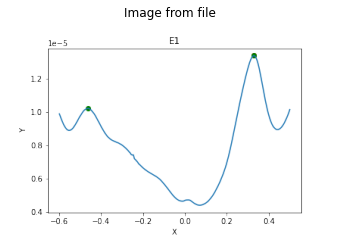

In [97]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the path to your image file
image_path = '../plots/E1.png'

# Load the image
img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title('Image from file')
plt.show()

In [98]:
from IPython.display import display, HTML

display(HTML(df_Input.to_html()))

,MaxPeak_X,MaxPeak_Y,NoPeaks,Area
0,0.328674,0.000013,2.0,0.000009


Extract the output of the decision tree classifier. Each experiment involved the use of 3 siderophores : Pyociannina, Aerobactin and Enterobactin, in different quantities (0 mmol, 25 mmol, 50 mmol, 100 mmol). Data associated for each experiment was extracted.

In [99]:
import openpyxl
import pandas as pd

# Load the Excel file
file_path = '../data/Data.xlsx'
wb = openpyxl.load_workbook(file_path, data_only=True)
sheet_name = 'Citiri date 14.05.24'
ws = wb[sheet_name]

# Define the range of rows and columns to read
start_row = 11
end_row = 11
start_col = 'B'
end_col = 'E'

# Read data into a list of lists
data = []
for row in ws.iter_rows(min_row=start_row, max_row=end_row, min_col=openpyxl.utils.column_index_from_string(start_col), max_col=openpyxl.utils.column_index_from_string(end_col)):
    row_data = []
    for cell in row:
        row_data.append(cell.value)
    data.append(row_data)

# Create a DataFrame from the data
dfInfo = pd.DataFrame(data, columns=['Exp', 'PyoC', 'AeB', 'EnB'])

# Print the DataFrame
print(dfInfo)

  Exp  PyoC  AeB  EnB
0  E1     0    0    0


Create an one-hot-encoding for the output dataframe. 

For example, in experiment 0, there were used 0 mmol of Pyoc, 0 mmol of AeB and 0 mmol of EnB. 

Therefore, the one hot-encoded version looked like: 

    - PyoC_0:   1	
    - PyoC_25:  0	
    - PyoC_50:  0
    - PyoC_100: 0
    - AeB_0:    1	
    - AeB_25:   0	
    - AeB_50:   0
    - AeB_100:  0
    - EnB_0:    1	
    - EnB_25:   0	
    - EnB_50:   0
    - EnB_100:  0

In [100]:
import pandas as pd

# One-hot encode the specified columns
df_Output = pd.get_dummies(dfInfo, columns=['PyoC', 'AeB', 'EnB'], prefix=['PyoC', 'AeB', 'EnB'])

# Reorder the columns to match the specified format
columns_order = [
    'PyoC_0', 'PyoC_25', 'PyoC_50', 'PyoC_100',
    'AeB_0', 'AeB_25', 'AeB_50', 'AeB_100',
    'EnB_0', 'EnB_25', 'EnB_50', 'EnB_100'
]

# Add missing columns with zeros if any are missing
for col in columns_order:
    if col not in df_Output:
        df_Output[col] = 0

# Reorder the DataFrame to have the columns in the desired order
df_Output = df_Output[columns_order]

In [101]:
from IPython.display import display, HTML

display(HTML(df_Output.to_html()))

,PyoC_0,PyoC_25,PyoC_50,PyoC_100,AeB_0,AeB_25,AeB_50,AeB_100,EnB_0,EnB_25,EnB_50,EnB_100
0,1,0,0,0,1,0,0,0,1,0,0,0


Concatenate input (Max Peak, No Peaks, Area) with output (one-hot encoded version of siderophores and their concentration)

In [102]:
# Concatenate the two DataFrames column-wise
df_concatenated = pd.concat([df_Input, df_Output], axis=1)

# Display the concatenated DataFrame
print(df_concatenated)

   MaxPeak_X  MaxPeak_Y  NoPeaks      Area  PyoC_0  PyoC_25  PyoC_50  \
0   0.328674   0.000013      2.0  0.000009       1        0        0   

   PyoC_100  AeB_0  AeB_25  AeB_50  AeB_100  EnB_0  EnB_25  EnB_50  EnB_100  
0         0      1       0       0        0      1       0       0        0  


Declare input and output columns

In [103]:
# Columns
all_input_cols = [  'MaxPeak_X',
                    'MaxPeak_Y',
                    'NoPeaks',
                    'Area'
                   ]

all_output_cols = ['PyoC_0','PyoC_25','PyoC_50','PyoC_100','AeB_0','AeB_25','AeB_50','AeB_100','EnB_0','EnB_25','EnB_50','EnB_100']

In [104]:
# Separate features (input) and target (output)
X = df_concatenated[all_input_cols]
y = df_concatenated[all_output_cols]

In [105]:
X

,MaxPeak_X,MaxPeak_Y,NoPeaks,Area
0,0.328674,0.000013,2.0,0.000009


In [106]:
y

,PyoC_0,PyoC_25,PyoC_50,PyoC_100,AeB_0,AeB_25,AeB_50,AeB_100,EnB_0,EnB_25,EnB_50,EnB_100
0,1,0,0,0,1,0,0,0,1,0,0,0


In [107]:
X = X.values
y = y.values

In [108]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

Train test split: 80% training size, 20% test size.

In [ ]:
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Create the decision tree classifier, fit the training dataset and predict based on test dataset 

In [ ]:
# # Create Decision Tree classifer object
# clf = DecisionTreeClassifier()

# # Train Decision Tree Classifer
# clf = clf.fit(X_train,y_train)

# #Predict the response for test dataset
# y_pred = clf.predict(X_test)

Load model

In [109]:
import pickle

# Load the model from the file
with open('../model/model.pkl', 'rb') as file:
    clf = pickle.load(file)

# Test the loaded model
print("Model loaded successfully using pickle!")

Model loaded successfully using pickle!


Predict output of training sample. (not very concludent)

In [110]:
#Predict the response for test dataset
y_pred = clf.predict(X)

In [111]:
y

array([[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]], dtype=int64)

In [112]:
y_pred

array([[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]], dtype=int64)